# Imminent ICU Admission and Prolonged Stay Prediction using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/lr'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'modeldir': PosixPath('../data/workdir/lr/models'),
 'min_freq': 3,
 'ia_thresh': 0.5,
 'ps_thresh': 0.47,
 'start_seed': 127}

## LR Model Dev

In [3]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = ori_df[args.prolonged_stay_cols].copy()

print(ia_df.shape)
print(ps_df.shape)

(50809, 3)
(75271, 3)


### Predict Imminent ICU Admission

In [4]:
df = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (43074, 56635), (7735, 56635), (43074,), (7735,))

In [5]:
params = {
  'class_weight': 'balanced',
  'solver': 'liblinear',
  'multi_class': 'ovr',
  'dual': True,
  'C': 0.336
}

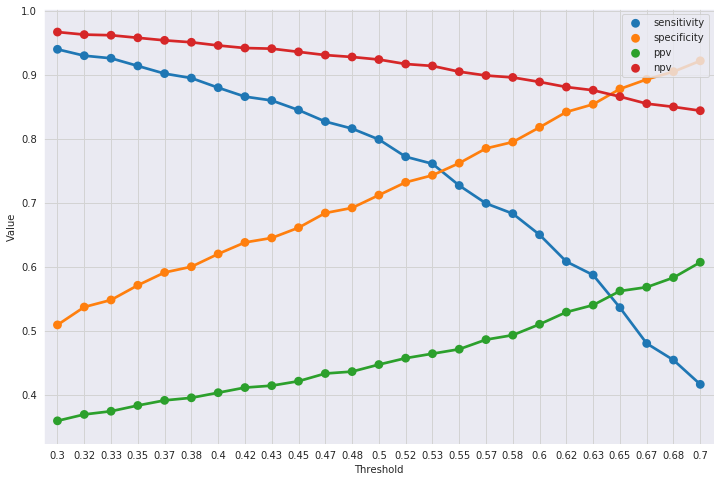

In [6]:
clf = LogisticRegression(**params)

clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [ ]:
args.imminent_threshold = 0.5
y_pred = (prob > args.imminent_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

In [ ]:
scores = clf.coef_[0]/clf.coef_[0].sum()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Delayed ICU Admission')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Imminent ICU Admission')

### Predict Prolonged ICU Stay

In [7]:
df = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((75271, 4), (64241, 66467), (11030, 66467), (64241,), (11030,))

In [8]:
params = {
  'class_weight': 'balanced',
  'solver': 'liblinear',
  'multi_class': 'ovr',
  'dual': True,
  'C': 0.145
}

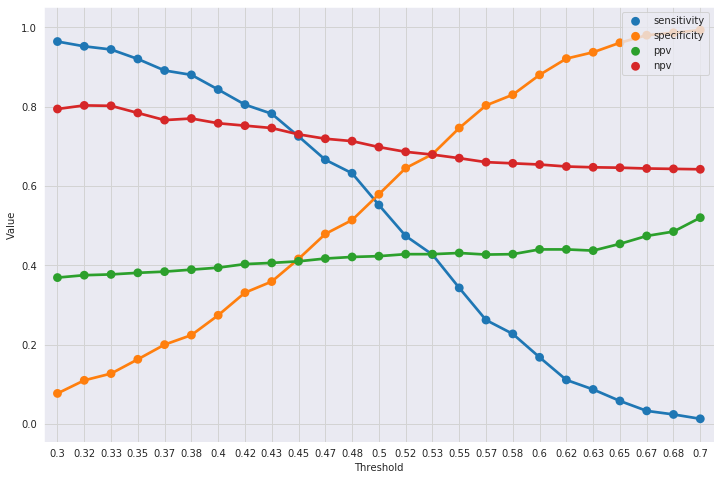

In [9]:
clf = LogisticRegression(**params)

clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [ ]:
args.discharge_threshold = 0.47
y_pred = (prob > args.discharge_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

In [ ]:
scores = clf.coef_[0]/clf.coef_[0].sum()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Short Stay')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Prolonged Stay')

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

### Imminent ICU Admission

In [ ]:
with open(args.workdir/f'imminent_adm_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'imminent_adm_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, bam.cm_avg, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

### Prolonged ICU Stay

In [ ]:
with open(args.workdir/f'prolonged_stay_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'prolonged_stay_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, bam.cm_avg, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

## Full Data

In [ ]:
df = pd.read_csv(args.dataset_csv, usecols=args.full_run_cols, parse_dates=args.dates)
df['relative_charttime'] = (df['charttime'] - df['intime'])

imminent_df = df.loc[(df['imminent_label'] != -1)][['scispacy_note', 'imminent_label', 'relative_charttime']].reset_index()
discharge_df = df[['scispacy_note', 'discharge_label', 'relative_charttime']].reset_index()

### Imminent ICU Admission

In [ ]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x = vectorizer.fit_transform(imminent_df['scispacy_note'])
y = imminent_df['imminent_label'].to_numpy()
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x, y)
imminent_df['prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

In [ ]:
with open(args.workdir/'imminent_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = -1

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, imminent_df, args.imminent_threshold, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.coef_[0]/clf.coef_[0].sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### ICU Discharge

In [ ]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x = vectorizer.fit_transform(discharge_df['scispacy_note'])
y = discharge_df['discharge_label'].to_numpy()
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x, y)
discharge_df['prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

In [ ]:
with open(args.workdir/'discharge_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = 0

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, discharge_df, args.discharge_threshold, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.coef_[0]/clf.coef_[0].sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')